
XGBoost Evaluation with Best Threshold:
Optimal Threshold: 0.3125
Adjusted Accuracy: 0.9801
Classification Report with Best Threshold:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99    113975
           1       0.77      0.62      0.69      4133

    accuracy                           0.98    118108
   macro avg       0.88      0.81      0.84    118108
weighted avg       0.98      0.98      0.98    118108

ROC-AUC Score with Best Threshold: 0.9436
Logistic Regression Accuracy: 0.9387933078199614
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.96      0.97    113975
           1       0.28      0.49      0.36      4133

    accuracy                           0.94    118108
   macro avg       0.63      0.72      0.66    118108
weighted avg       0.96      0.94      0.95    118108

ROC-AUC Score: 0.8357715203949911

Random Forest Evaluation with Best Threshold:
Optimal Thres

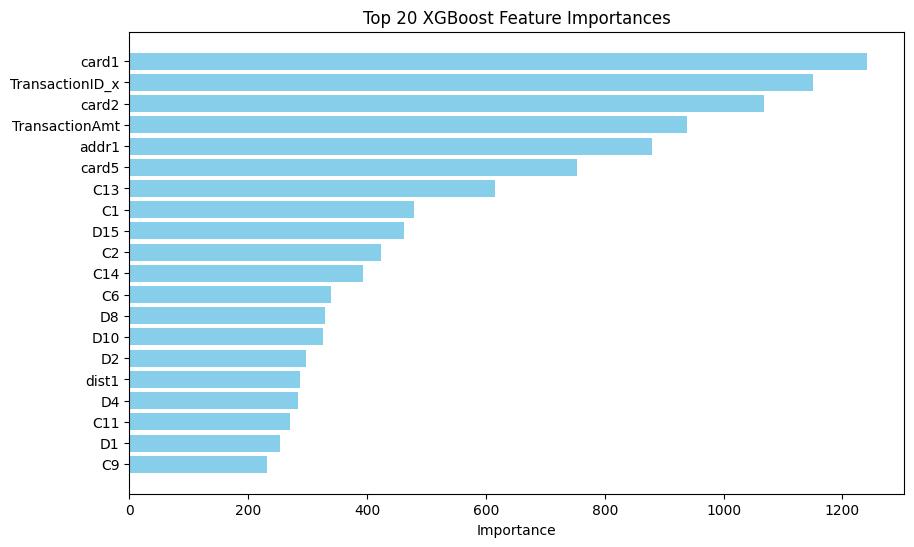

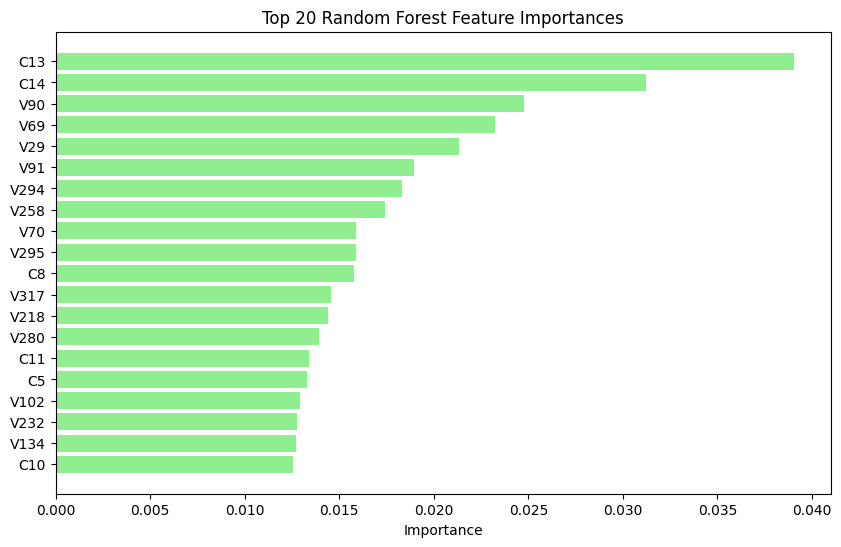

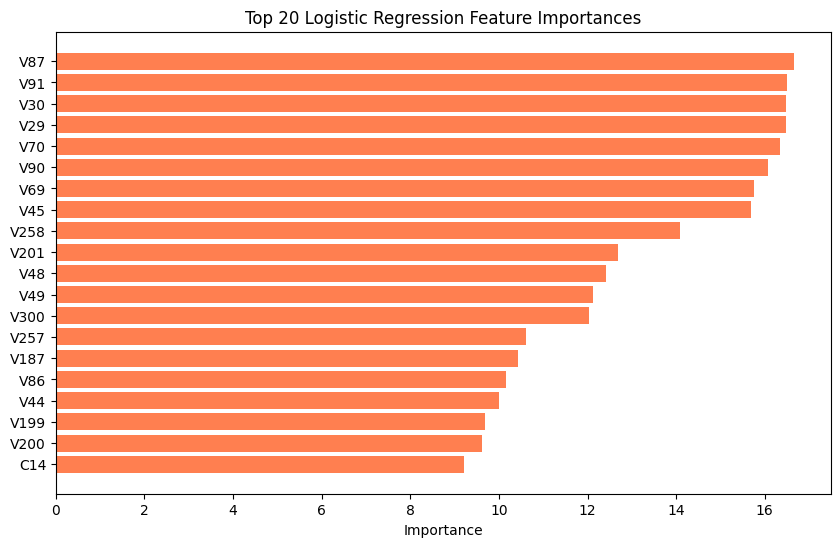

: 

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, precision_recall_curve
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

# Load the datasets
train_transactions = pd.read_csv('dataset2-ieee-fraud-detection/train_transaction.csv')
train_identity = pd.read_csv('dataset2-ieee-fraud-detection/train_identity.csv')

# Merge the datasets on the index
train = train_transactions.merge(train_identity, how='left', left_index=True, right_index=True)
# Extract the target variable
y = train['isFraud'].astype('uint8')

# Check and remove duplicate rows
train.drop_duplicates(inplace=True)

# Convert 'TransactionDT' to datetime format 
train['TransactionDT'] = pd.to_datetime(train['TransactionDT'], unit='s', errors='coerce')

# Ensure all columns that should be numeric are converted
numeric_columns = train.select_dtypes(include=['object']).columns
for col in numeric_columns:
    train[col] = pd.to_numeric(train[col], errors='coerce')

# Drop rows where 'isFraud' is NaN
train = train.dropna(subset=['isFraud'])

# Drop unnecessary columns or those not needed for modeling
columns_to_drop = ['TransactionDT', 'ProductCD']
train.drop(columns=columns_to_drop, inplace=True, errors='ignore')

# Define features and target variable
X = train.drop(columns=['isFraud'])
y = train['isFraud']

# Convert categorical columns to numeric using one-hot encoding
X = pd.get_dummies(X, drop_first=True)

# Handle missing values
X = X.fillna(-999)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale the relevant numeric columns using StandardScaler
scaler = StandardScaler()
numeric_features = X_train.select_dtypes(include=['float64', 'int64']).columns
X_train[numeric_features] = scaler.fit_transform(X_train[numeric_features])
X_test[numeric_features] = scaler.transform(X_test[numeric_features])

# Apply SMOTE to balance the classes in the training data
smote = SMOTE(sampling_strategy=0.4, random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

### Train the XGBoost Model
clf_xgb = XGBClassifier(
    n_estimators=100,
    max_depth=10,
    learning_rate=0.2,
    subsample=0.75,
    colsample_bytree=0.75,
    random_state=42
)
clf_xgb.fit(X_train_resampled, y_train_resampled)
# Initialise the logistic regression model
model_log_reg = LogisticRegression(max_iter=10000, random_state=42)

# Train the model on the resampled training data
model_log_reg.fit(X_train_resampled, y_train_resampled)

# Predict on the test set
y_pred = model_log_reg.predict(X_test)
### Train the Random Forest Model
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=15,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train_resampled, y_train_resampled)

### Evaluation Function to Print Results for the Best Threshold
def evaluate_model(model, X_test, y_test, model_name="Model"):

    # Predict on the test set
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    # Calculate precision, recall, and thresholds for different thresholds
    precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)
    f1_scores = 2 * (precision * recall) / (precision + recall)
    optimal_idx = np.argmax(f1_scores)  # Find the threshold that maximizes F1 score
    optimal_threshold = thresholds[optimal_idx]

    # Predict using the adjusted threshold
    y_pred_adjusted = (y_pred_proba >= optimal_threshold).astype(int)

    # Print evaluation results with adjusted threshold
    print(f"\n{model_name} Evaluation with Best Threshold:")
    print(f"Optimal Threshold: {optimal_threshold:.4f}")
    print(f"Adjusted Accuracy: {accuracy_score(y_test, y_pred_adjusted):.4f}")
    print("Classification Report with Best Threshold:\n", classification_report(y_test, y_pred_adjusted))
    print(f"ROC-AUC Score with Best Threshold: {roc_auc_score(y_test, y_pred_proba):.4f}")

# Evaluate the XGBoost model
evaluate_model(clf_xgb, X_test, y_test, model_name="XGBoost")

# Evaluate the Logistic Regression model
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, model_log_reg.predict_proba(X_test)[:, 1]))

# Evaluate the Random Forest model
evaluate_model(rf_model, X_test, y_test, model_name="Random Forest")

### Plotting Functions for Feature Importance

# XGBoost Feature Importance
def plot_xgboost_feature_importance(model, X_train, top_n=20):
    xgb_importance = model.get_booster().get_score(importance_type='weight')
    importance_df = pd.DataFrame({'Feature': list(xgb_importance.keys()), 'Importance': list(xgb_importance.values())})
    importance_df = importance_df.sort_values(by='Importance', ascending=False).head(top_n)

    plt.figure(figsize=(10, 6))
    plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
    plt.gca().invert_yaxis()
    plt.title(f'Top {top_n} XGBoost Feature Importances')
    plt.xlabel('Importance')
    plt.show()

plot_xgboost_feature_importance(clf_xgb, X_train, top_n=20)

# Random Forest Feature Importance
def plot_rf_feature_importance(model, X_train, top_n=20):
    rf_importance = model.feature_importances_
    feature_names = X_train.columns
    importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': rf_importance})
    importance_df = importance_df.sort_values(by='Importance', ascending=False).head(top_n)

    plt.figure(figsize=(10, 6))
    plt.barh(importance_df['Feature'], importance_df['Importance'], color='lightgreen')
    plt.gca().invert_yaxis()
    plt.title(f'Top {top_n} Random Forest Feature Importances')
    plt.xlabel('Importance')
    plt.show()

plot_rf_feature_importance(rf_model, X_train, top_n=20)

# Logistic Regression Feature Importance
def plot_logistic_regression_coefficients(model, X_train, top_n=20):
    coef = model.coef_.flatten()
    feature_names = X_train.columns
    coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coef})
    coef_df['Importance'] = np.abs(coef_df['Coefficient'])
    coef_df = coef_df.sort_values(by='Importance', ascending=False).head(top_n)

    plt.figure(figsize=(10, 6))
    plt.barh(coef_df['Feature'], coef_df['Importance'], color='coral')
    plt.gca().invert_yaxis()
    plt.title(f'Top {top_n} Logistic Regression Feature Importances')
    plt.xlabel('Importance')
    plt.show()

plot_logistic_regression_coefficients(model_log_reg, X_train, top_n=20)
